In [2]:
#Importing Libraries
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

# LOADING DATA
* list of all the songs in the Chopin
* extract chords and notes

In [5]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


## **Loading the list of chopin's midi files as stream**

In [6]:
import os
filepath = "../content/drive/MyDrive/mozart/"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

## **Exctract notes**

In [7]:
#Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the mozart midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 59618


# DATA EXPLORATION
* Exploring the data Corpus
* Examine all the notes in the Corpus 
* Simplifying our Corpus 

## **first 50 values in our corpus**

In [8]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['B4', 'A4', 'G#4', 'A4', 'C5', 'A3', '0.4', 'D5', '0.4', 'C5', 'B4', '0.4', 'C5', 'E5', 'A3', '0.4', 'F5', '0.4', 'E5', 'E-5', '0.4', 'E5', 'B5', 'A3', 'A5', 'G#5', '0.4', 'A5', 'B5', 'A3', 'A5', 'G#5', '0.4', 'A5', 'C6', 'A3', '0.4', 'A5', '0.4', 'C6', '0.4', '7.9', 'B5', 'E3', '6.9', '11.4', '4.7', '11.4', '6.9', '11.4']


## **Extract Melody_Snippet**

In [9]:

    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])


## **Creating a count dictionary**

In [10]:
count_num = Counter(Corpus) 
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 197


## **Exploring the notes dictionary**

In [11]:
Notes = list(count_num.keys())
Recurrence = list(count_num.values())

## **Average occurrence for a note in Corpus**

In [12]:
def Average(lst):
    return sum(lst) / len(lst)
print("Average occurrence for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average occurrence for a note in Corpus: 302.6294416243655
Most frequent note in Corpus appeared: 3116 times
Least frequent note in Corpus appeared: 1 time


## **Plotting the distribution of Notes**

**decided to remove the notes that were played less than 100 times**

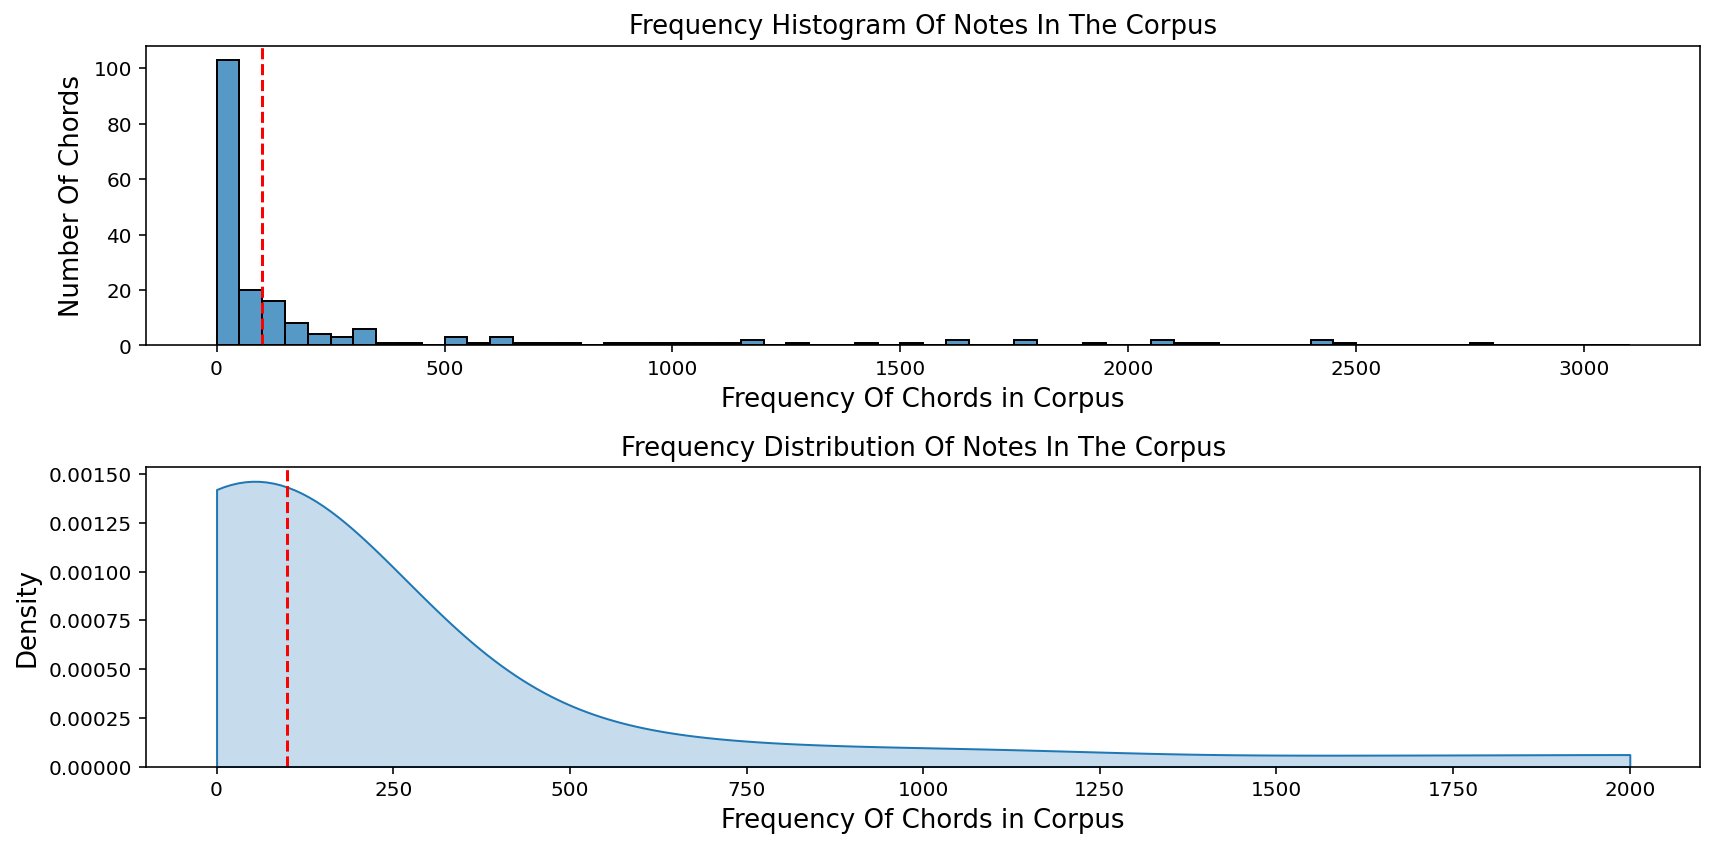

In [13]:
# setting a thereshold
teta=100

import seaborn as sns
fig,ax=plt.subplots(2,1,figsize=(12,6))
bins = np.arange(0,max(Recurrence), 50) 
sns.histplot(Recurrence, bins=bins , ax=ax[0])
sns.kdeplot(Recurrence, ax=ax[1],clip=[0,2000],shade=True)
for i in range(2):
  ax[i].axvline(x=teta,ls='--',color='red')
  ax[i].set_xlabel("Frequency Of Chords in Corpus",size=13)

ax[0].set_title("Frequency Histogram Of Notes In The Corpus",size=13)
ax[1].set_title("Frequency Distribution Of Notes In The Corpus",size=13)
ax[0].set_ylabel("Number Of Chords",size=13)
ax[1].set_ylabel("Density",size=13)
plt.tight_layout()
plt.show()

## **Getting a list of rare chords**

In [14]:
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < teta:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 123


## **Eleminating the rare notes**

In [15]:
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 57247


# DATA PREPROCESSING
* Creating a dictionary
* Encoding and Splitting the corpus
* Assigning X and y
* Splitting Train and Seed datasets
* Creating a list of sorted unique characters


## **Creating a dictionary**

### Storing all the unique characters present in my corpus to bult a mapping dic. 

In [16]:
symb = sorted(list(set(Corpus)))
L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

### Building dictionary to access the vocabulary from indices and vice versa

In [17]:
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 57247
Number of unique characters: 140


## **Splitting the Corpus in equal length of strings and output target**

In [18]:
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

## **Encoding and Splitting the Corpus as Labels and Targets**

In [19]:
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 57207


# Preprocessing

## **reshape X and normalize**

In [20]:
from sklearn.preprocessing import MinMaxScaler
# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

## **Splitting Train and Seed datasets**

In [21]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

<a id="5"></a>
# <p style="background-color:#97BACB;font-family:newtimeroman;color:#EBDDD0;font-size:120%;text-align:center;border-radius:40px 40px;">MODEL BUILDING</p>
* Initialising the Model
* Defining by adding layers
* Compiling the Model
* Training the Model



# **Implementing model (without dropout)**

In [22]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [23]:
with tf.device('/device:GPU:0'):
  #Initialising the Model
  model = Sequential()
  #Adding layers
  model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
  #model.add(Dropout(0.1))
  model.add(LSTM(256))
  model.add(Dense(256))
  #model.add(Dropout(0.1))
  model.add(Dense(y.shape[1], activation='softmax'))
  #Compiling the model for training  
  opt = Adamax(learning_rate=0.01)
  model.compile(loss='categorical_crossentropy', optimizer=opt)

In [24]:
#Model's Summary               
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 140)               35980     
                                                                 
Total params: 1,941,900
Trainable params: 1,941,900
Non-trainable params: 0
_________________________________________________________________


#Training the Model

In [25]:
history = model.fit(X_train, y_train, batch_size=256, epochs=200)

Epoch 1/200
179/179 [==============================] - 13s 39ms/step - loss: 4.0222
Epoch 2/200
179/179 [==============================] - 7s 39ms/step - loss: 3.8983
Epoch 3/200
179/179 [==============================] - 7s 39ms/step - loss: 3.8943
Epoch 4/200
179/179 [==============================] - 7s 39ms/step - loss: 3.8904
Epoch 5/200
179/179 [==============================] - 7s 39ms/step - loss: 3.8833
Epoch 6/200
179/179 [==============================] - 7s 40ms/step - loss: 3.8821
Epoch 7/200
179/179 [==============================] - 7s 40ms/step - loss: 3.8810
Epoch 8/200
179/179 [==============================] - 7s 40ms/step - loss: 3.8772
Epoch 9/200
179/179 [==============================] - 7s 40ms/step - loss: 3.8713
Epoch 10/200
179/179 [==============================] - 7s 41ms/step - loss: 3.8698
Epoch 11/200
179/179 [==============================] - 7s 41ms/step - loss: 3.8705
Epoch 12/200
179/179 [==============================] - 7s 41ms/step - loss: 3.8634


## **Plotting the learnings**

[Text(0.5, 0, 'Epochs')]

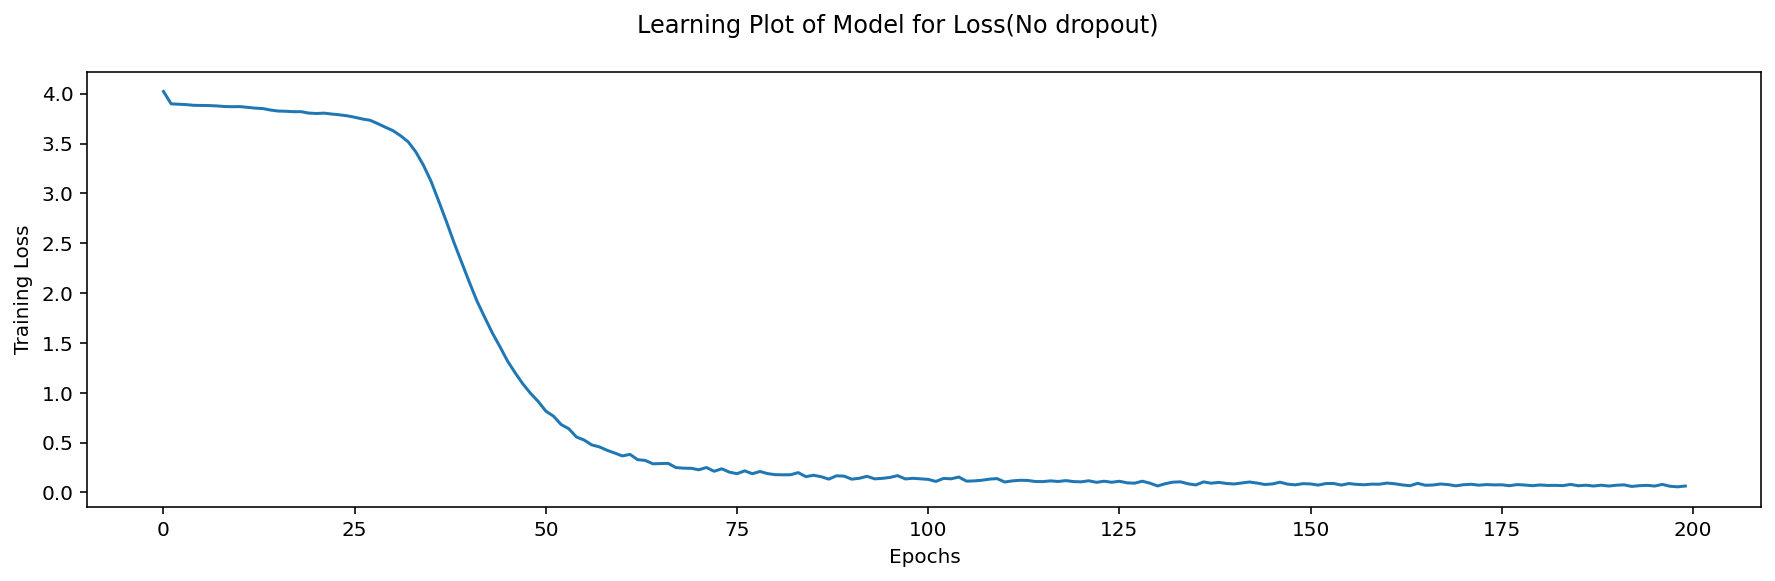

In [26]:
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4))
fig.suptitle("Learning Plot of Model for Loss(No dropout)")
pl=sns.lineplot(data=history_df["loss"])
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [27]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi

## **getting the Notes and Melody created by the model**

In [28]:
Music_notes, Melody = Malody_Generator(100)

## **To save the generated melody**

In [31]:
Melody.write('midi','Melody_Generated3.mid')

'Melody_Generated3.mid'

## **to play audio or corpus**

In [32]:
IPython.display.Audio("../content/drive/MyDrive/Input_Output/Melody_Generated3.wav")

# **Implementing model (with dropoutrate=0.1)**

In [33]:
with tf.device('/device:GPU:0'):
  #Initialising the Model
  model = Sequential()
  #Adding layers
  model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
  model.add(Dropout(0.1))
  model.add(LSTM(256))
  model.add(Dense(256))
  model.add(Dropout(0.1))
  model.add(Dense(y.shape[1], activation='softmax'))
  #Compiling the model for training  
  opt = Adamax(learning_rate=0.01)
  model.compile(loss='categorical_crossentropy', optimizer=opt)

In [34]:
#Model's Summary               
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               787456    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 140)               35980     
                                                                 
Total params: 1,941,900
Trainable params: 1,941,900
No

#Training the Model

In [35]:
history = model.fit(X_train, y_train, batch_size=256, epochs=200)

Epoch 1/200
179/179 [==============================] - 10s 42ms/step - loss: 3.9674
Epoch 2/200
179/179 [==============================] - 8s 43ms/step - loss: 3.8993
Epoch 3/200
179/179 [==============================] - 8s 43ms/step - loss: 3.8970
Epoch 4/200
179/179 [==============================] - 8s 44ms/step - loss: 3.8961
Epoch 5/200
179/179 [==============================] - 8s 44ms/step - loss: 3.8940
Epoch 6/200
179/179 [==============================] - 8s 45ms/step - loss: 3.8930
Epoch 7/200
179/179 [==============================] - 8s 46ms/step - loss: 3.8890
Epoch 8/200
179/179 [==============================] - 8s 46ms/step - loss: 3.8800
Epoch 9/200
179/179 [==============================] - 8s 45ms/step - loss: 3.8525
Epoch 10/200
179/179 [==============================] - 8s 45ms/step - loss: 3.8490
Epoch 11/200
179/179 [==============================] - 8s 44ms/step - loss: 3.8294
Epoch 12/200
179/179 [==============================] - 8s 44ms/step - loss: 3.8197


## **Plotting the learnings**

[Text(0.5, 0, 'Epochs')]

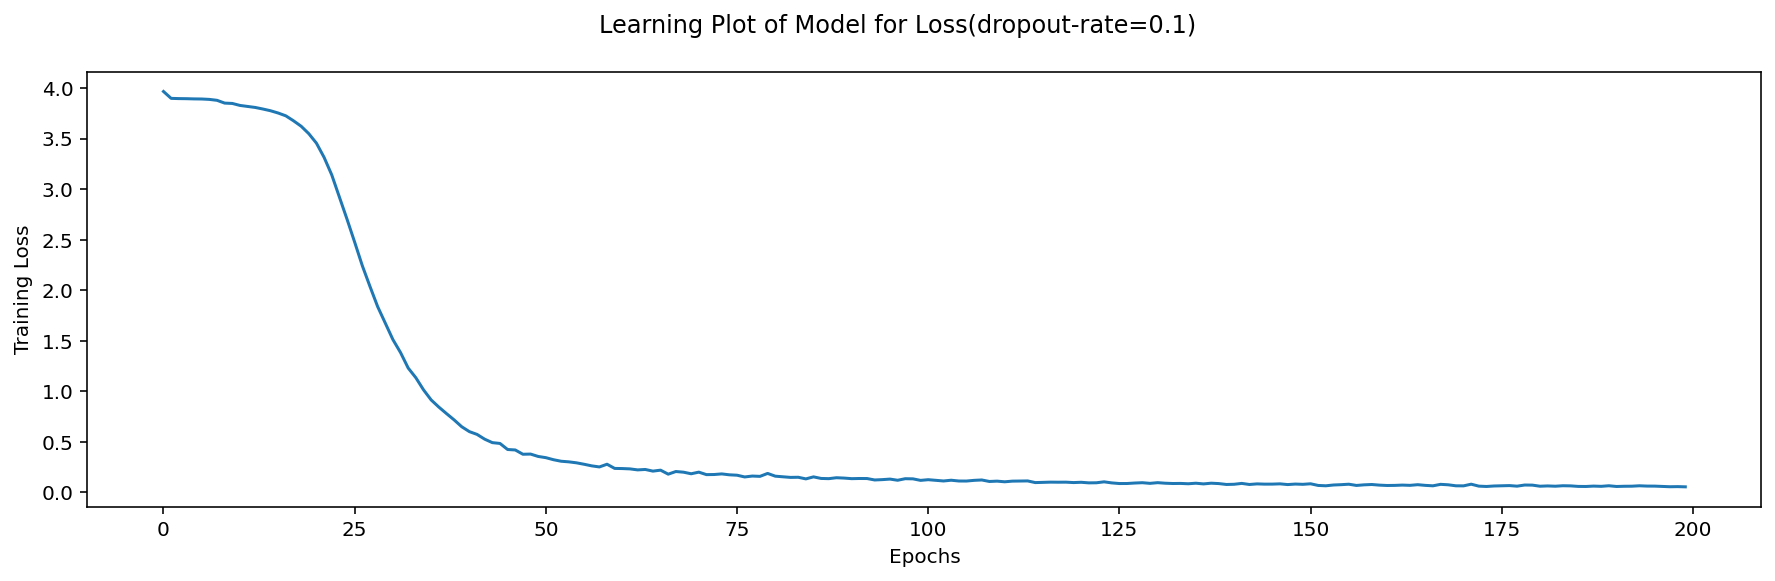

In [36]:
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4))
fig.suptitle("Learning Plot of Model for Loss(dropout-rate=0.1)")
pl=sns.lineplot(data=history_df["loss"])
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

## **getting the Notes and Melody created by the model**

In [37]:
Music_notes, Melody = Malody_Generator(100)

## **To save the generated melody**

In [38]:
Melody.write('midi','Melody_Generated4.mid')

'Melody_Generated4.mid'

## **to play audio or corpus**

In [39]:
IPython.display.Audio("../content/drive/MyDrive/Input_Output/Melody_Generated4.wav")